In [1]:
# common

from widgets.data import Data
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelextrema, medfilt
import scipy.interpolate as si

cell = "Bigelowiella" # "Bigelowiella" "Cryptomonas" "Penium" "a"
data = Data(f"./data/{cell}.mat")

def get_indices_range(x, start_value, end_value):
    start_index = np.argmin(np.absolute(x - start_value))
    end_index = np.argmin(np.absolute(x - end_value))
    return np.r_[start_index:end_index]

def get_indices_to_fit(x, ranges_to_ignore):
    union = reduce(np.union1d, (get_indices_range(x, *i) for i in ranges_to_ignore))
    to_fit = np.in1d(np.arange(x.shape[0]), union, invert=True)
    return to_fit

def erosion(values: np.ndarray, window_width: int) -> np.ndarray: # start with 1 (structuring element has then size 3 (2 * w_w + 1))
    # eroze -> minmum v okně
    padded_values = np.pad(values, (window_width, window_width), 'constant', constant_values=(values[0], values[-1])) # pad with side values from sides
    windows = np.lib.stride_tricks.sliding_window_view(padded_values, 2 * window_width + 1)
    mins = np.min(windows, axis=1)
    return mins

def dilation(values: np.ndarray, window_width: int) -> np.ndarray:
    # dilatace -> maximum v okně
    padded_values = np.pad(values, (window_width, window_width), 'constant', constant_values=(values[0], values[-1])) # pad with side values from sides
    windows = np.lib.stride_tricks.sliding_window_view(padded_values, 2 * window_width + 1)
    mins = np.max(windows, axis=1)
    return mins

def opening(values: np.ndarray, window_width: int) -> np.ndarray:
    return dilation(erosion(values, window_width), window_width)

def get_optimal_structuring_element_width(values : np.ndarray) -> int:
    max_sim_counter = 3 # zmena oproti navrhovanemu algoritmu, potrebujeme vice (4 nebo 5 se zda byt ok)
    window_width = 1
    opened_array = opening(values, window_width)

    while True:
        window_width += 1
        new_opened_array = opening(opened_array, window_width)
        if np.any(new_opened_array != opened_array):
            similarity_counter = 0
            opened_array = new_opened_array
            continue
        else:
            similarity_counter += 1
            if similarity_counter == max_sim_counter:
                return window_width - max_sim_counter + 1 # restore window width of the first similar result

def plot(x, y, bg):
    fig = plt.figure(figsize=(25, 10))
    fig.add_subplot(1, 2, 1)

    # spectrum with BG
    plt.plot(x, y)
    plt.plot(x, bg, label="estimated background")
    plt.title("Spectrum with background")
    plt.legend()

    fig.add_subplot(1, 2, 2)

    # spectrum without BG
    plt.plot(x, y - bg - np.min(y - bg))
    plt.ylim(0, 100)
    plt.title("Spectrum without background")

    plt.tight_layout()
    plt.show()

# airPLS baseline correction
(https://raw.githubusercontent.com/zmzhang/airPLS/master/airPLS.py)

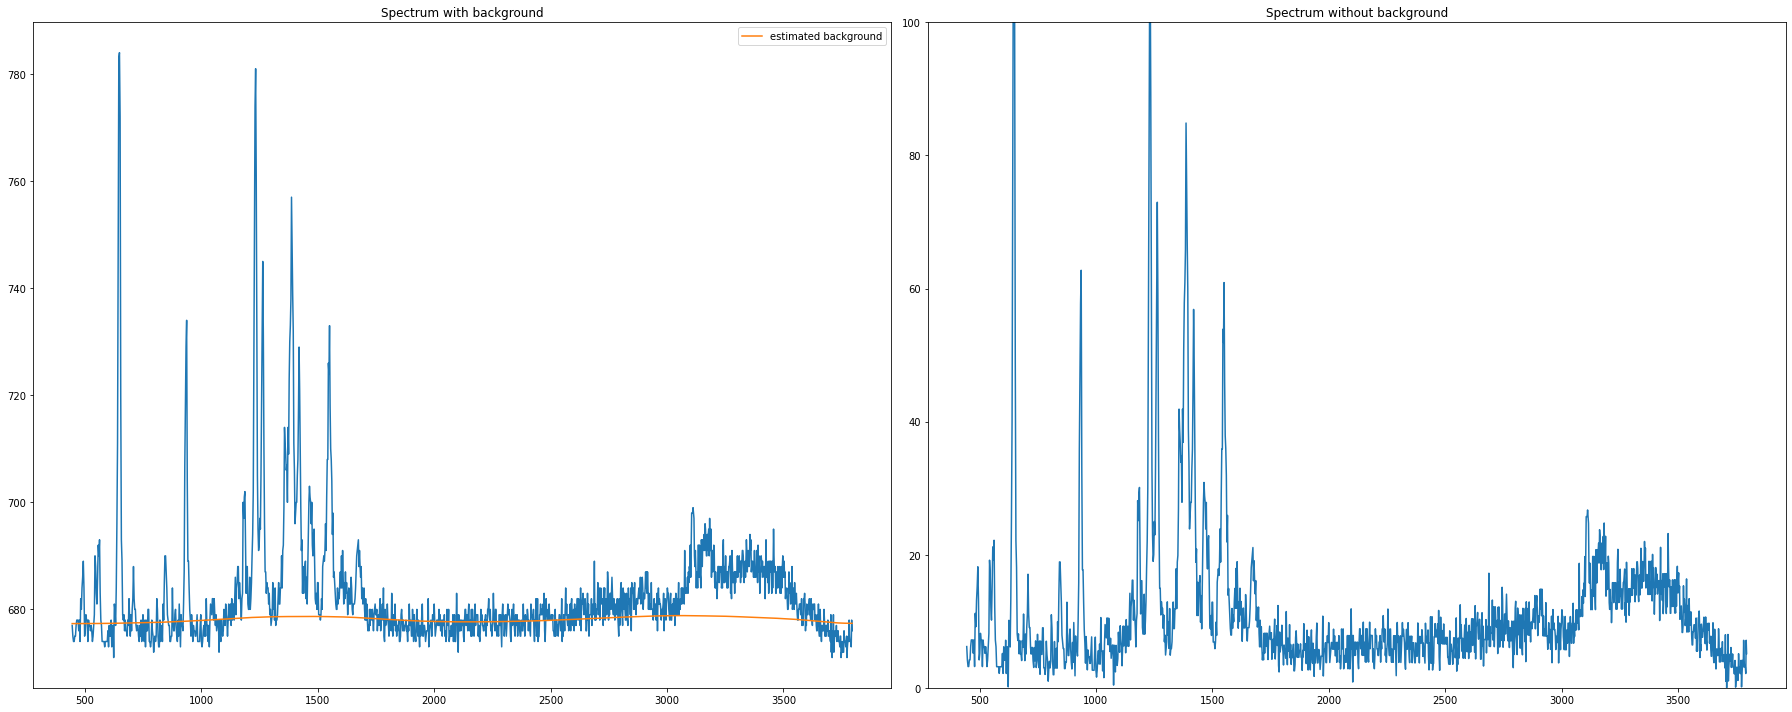

'\n- celkově funguje dobře a tato metoda sama od sebe ignoruje vodu pro dobře zvolenou lambdu (cca nad 7000), klidně i 20000 a výš\n- lze nějakým zůsobem zlepšit buď odhadováním pozadí `lower_envelope` vznilké určitou iterpolací lokálních minim; dále odhadem pozadí otevření spektra\n- výhody: není třeba dávat žádné indexy k ignorování, peaky se naučí ignorovat samo, lze použít v automatickém zpracování jednoduše, poměrně rychlé\n- nevýhody: je třeba zvolit lambdu\n\nTODO: určitě upravit algoritmus, něco napsat lépe\n'

In [25]:
def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    E=eye(m,format='csc')
    for i in range(differences):
        E=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*E.T*E))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=10**4.4, porder=1, itermax=20):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn)
        w[-1]=w[0]
    return z


y = data.data[27, 16, 80:-30]
x = data.x_axis[80:-30]

# misc
opt_ww = get_optimal_structuring_element_width(y[get_indices_range(x, 500, 3000)])
spectrum_opening = opening(y, opt_ww)
approximation = np.mean(erosion(spectrum_opening, opt_ww) + dilation(spectrum_opening, opt_ww), axis=0)
background_op = np.minimum(spectrum_opening, approximation)
min = argrelextrema(y, np.less)
min_indices = np.unique(np.append(np.insert(min[0], 0, 0), len(x)-1)) # insert points to avoid nans
min_spline = si.interp1d(x[min_indices], y[min_indices])
lower_envelope = medfilt(min_spline(x))

# plot(x,y,lower_envelope)
b = airPLS(y)
plot(x, y, b)

# erPLS -> auto lambda selection

"""
- celkově funguje dobře a tato metoda sama od sebe ignoruje vodu pro dobře zvolenou lambdu (cca nad 7000), klidně i 20000 a výš
- lze nějakým zůsobem zlepšit buď odhadováním pozadí `lower_envelope` vznilké určitou iterpolací lokálních minim; dále odhadem pozadí otevření spektra
- výhody: není třeba dávat žádné indexy k ignorování, peaky se naučí ignorovat samo, lze použít v automatickém zpracování jednoduše, poměrně rychlé
- nevýhody: je třeba zvolit lambdu

TODO: určitě upravit algoritmus, něco napsat lépe
"""

## Vancouver for further testing

In [4]:
def vancouver(degree: int, ignore_water: bool = True):
    backgrounds = np.apply_along_axis(vancouver_poly_bg, 2, data.data, degree, ignore_water)
    return data.data - backgrounds

def vancouver_poly_bg(y: np.ndarray, degree: int, ignore_water: bool = True) -> np.ndarray:
    x = data.x_axis

    if ignore_water:
        to_ignore = [[3000, 3750]]
        to_fit = get_indices_to_fit(data.x_axis, to_ignore)
        x = x[to_fit]
        y = y[to_fit]

    signal = y
    first_iter = True
    devs = [0]
    criterium = np.inf

    while criterium > 0.05:
        poly_obj = np.polynomial.Polynomial(None).fit(x, signal, deg=degree)
        poly = poly_obj(x)
        residual = signal - poly
        residual_mean = np.mean(residual)
        DEV = np.sqrt(np.mean((residual - residual_mean)**2))
        devs.append(DEV)
        
        if first_iter: # remove peaks from fitting in first iteration
            not_peak_indices = np.where(signal <= (poly + DEV))
            signal = signal[not_peak_indices]
            x = x[not_peak_indices]
            first_iter = False
        else: # reconstruction
            signal = np.where(signal < poly + DEV, signal, poly + DEV)
        criterium = np.abs((DEV - devs[-2]) / DEV)

    return poly_obj(data.x_axis)

bgless = np.reshape(vancouver(5, True), (-1, data.data.shape[-1]))

# PCA-based CRR

In [12]:
from sklearn import decomposition

print(bgless.T.shape)
pca = decomposition.PCA(0.85)
pca.fit(bgless.T)

(1600, 2500)


PCA(n_components=0.85)

In [13]:
components = pca.components_
print(components.shape)

# ?? :(

(1, 2500)


# CRR Z-score modification

COL data shape: (1599, 2500)
(1599,)
(1599, 2500)
(50, 50, 1599)
700.8055
0.00076282956
first done
ROW data shape: (2500, 1599)
(2500,)
(2500, 1599)
(50, 50, 1599)
423.586
0.0006565591
similarity test
True
end


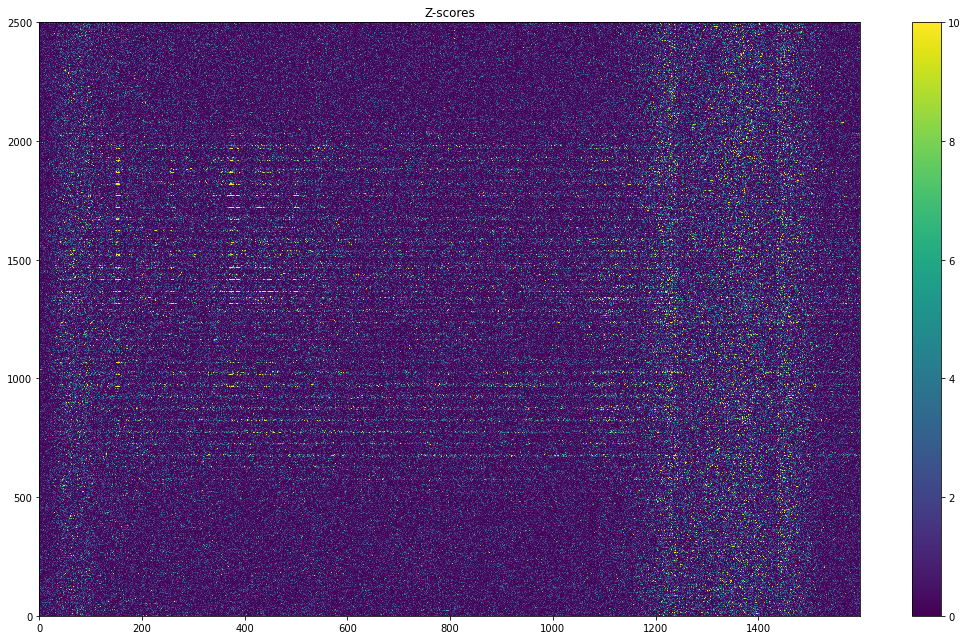

[(array([ 7, 32], dtype=int64), 4), (array([ 8, 11], dtype=int64), 3), (array([ 8, 32], dtype=int64), 2), (array([ 9, 11], dtype=int64), 3), (array([12, 45], dtype=int64), 4), (array([13, 45], dtype=int64), 2), (array([20, 17], dtype=int64), 1), (array([20, 18], dtype=int64), 1), (array([21, 16], dtype=int64), 2), (array([21, 17], dtype=int64), 1), (array([26, 15], dtype=int64), 1), (array([27, 15], dtype=int64), 5), (array([27, 16], dtype=int64), 11), (array([27, 17], dtype=int64), 8), (array([27, 18], dtype=int64), 2), (array([28, 15], dtype=int64), 9), (array([28, 16], dtype=int64), 11), (array([28, 17], dtype=int64), 14), (array([28, 18], dtype=int64), 7), (array([28, 42], dtype=int64), 3), (array([29, 14], dtype=int64), 3), (array([29, 15], dtype=int64), 2), (array([29, 16], dtype=int64), 5), (array([29, 17], dtype=int64), 6), (array([29, 18], dtype=int64), 5), (array([29, 42], dtype=int64), 3), (array([30, 14], dtype=int64), 3), (array([30, 17], dtype=int64), 1), (array([30, 23],

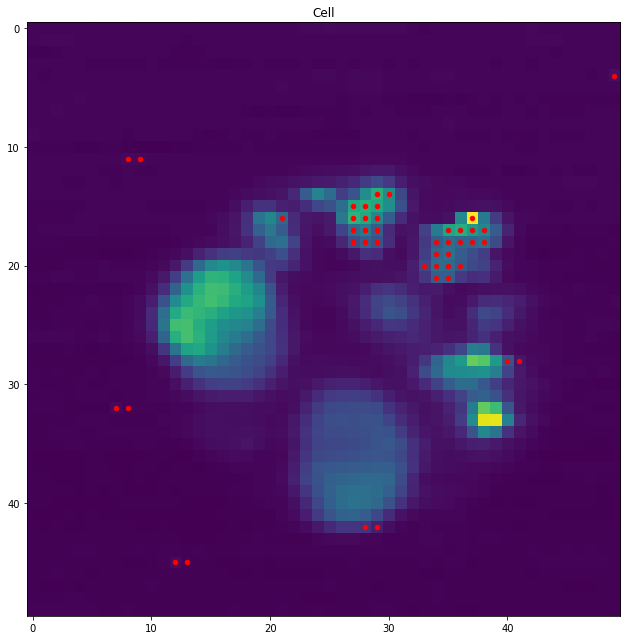

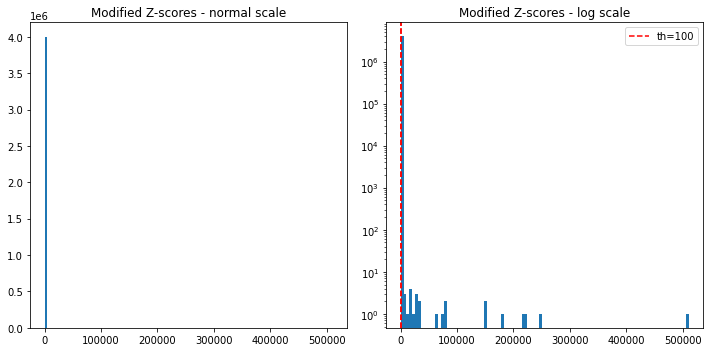

In [7]:
th = 100 # th zda se zavisi na bunce dost

col_data = np.reshape(data.data, (-1, data.data.shape[-1])).T
col_data = np.diff(col_data, axis=0)
print(f"COL data shape: {col_data.shape}")
M = np.median(col_data, axis=1)
print(M.shape)
wide_M = np.repeat(M[:,np.newaxis], col_data.shape[1], axis=1)
MAD = np.median(np.abs(col_data - wide_M), axis=1)
wide_MAD = np.repeat(MAD[:,np.newaxis], col_data.shape[1], axis=1)
Z = 0.6745 * (col_data - wide_M) / wide_MAD
print(Z.shape)
td_Z = np.reshape(Z.T, (data.data.shape[0], data.data.shape[1], -1))
print(td_Z.shape)

print(np.max(Z))
print(np.mean(Z))
print("first done")
# prev version of algo
row_data = np.reshape(data.data, (-1, data.data.shape[-1]))
row_data = np.diff(row_data, axis=1)
print(f"ROW data shape: {row_data.shape}")
M_row = np.median(row_data, axis=1)
print(M_row.shape)
wide_M_row = np.repeat(M_row[:,np.newaxis], row_data.shape[1], axis=1)
MAD_row = np.median(np.abs(row_data - wide_M_row), axis=1)
wide_MAD_row = np.repeat(MAD_row[:,np.newaxis], row_data.shape[1], axis=1)
Z_row = 0.6745 * (row_data - wide_M_row) / wide_MAD_row
print(Z_row.shape)
td_Z_row = np.reshape(Z_row, (data.data.shape[0], data.data.shape[1], -1))
print(td_Z_row.shape)

print(np.max(Z_row))
print(np.mean(Z_row))
# end
print("similarity test")
print(np.all(td_Z) == np.all(td_Z_row))
print("end")

plt.figure(figsize=(15,9))
c = plt.pcolormesh(np.abs(Z.T * Z_row), vmax=10)
plt.colorbar(c)
plt.axis('on')
plt.title("Z-scores")

plt.tight_layout()
plt.show()

new_td_Z = td_Z * td_Z_row

pos, counts = np.unique(np.vstack(np.where(np.abs(new_td_Z) > th)[:2]).T, axis=0, return_counts=True)
print(list(zip(pos, counts)))
pos = [pos for pos, count in zip(pos, counts) if count > 1] # take only spectra where there are at least 2 values exceeding threshold
# print(pos.shape)
x = [float(i[0]) for i in pos]
y = [float(i[1]) for i in pos]

#print(x)
#print(y)
plt.figure(figsize=(15,9))
plt.imshow(data.averages.T, zorder=1)
plt.scatter(x, y, color='red', zorder=2, s=20)
plt.axis('on')
plt.title("Cell")

plt.tight_layout()
plt.show()


# Z values histogram
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)

Z_vals = np.reshape(new_td_Z, (np.prod(new_td_Z.shape),))

plt.hist(Z_vals, 100, log=0)
# plt.axvline(x=3.5, color='red', linestyle='--', label=f"{3.5}")
# plt.axvline(x=-3.5, color='red', linestyle='--')
plt.axis('on')
plt.title("Modified Z-scores - normal scale")

fig.add_subplot(1, 2, 2)

# log scale
plt.hist(Z_vals, 100, log=1)
plt.axvline(x=th, color='red', linestyle='--', label=f"th={th}")
plt.axvline(x=-th, color='red', linestyle='--')
plt.axis('on')
plt.legend()
plt.title("Modified Z-scores - log scale")

plt.tight_layout()
plt.show()

print()

# CRR modified Z-score + clustering

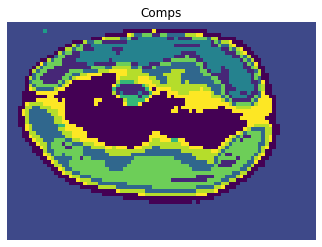

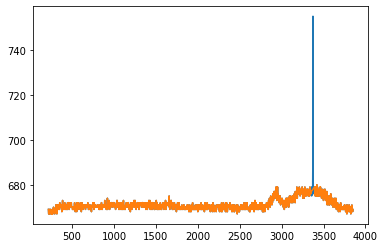

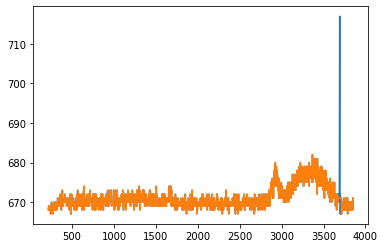

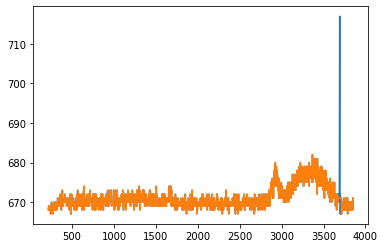

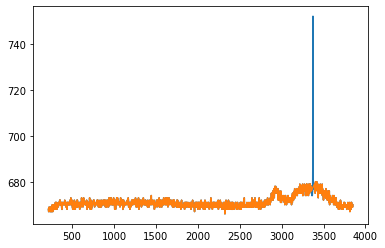

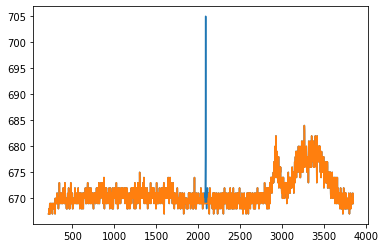

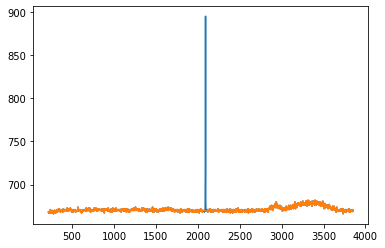

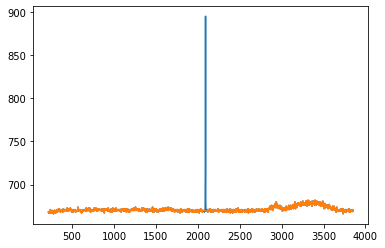

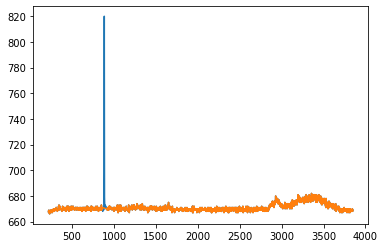

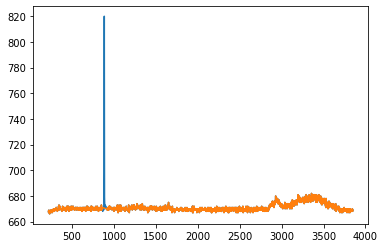

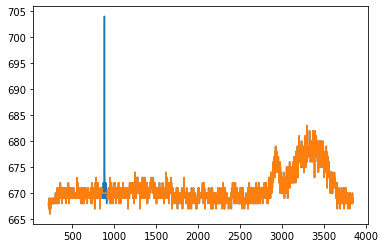

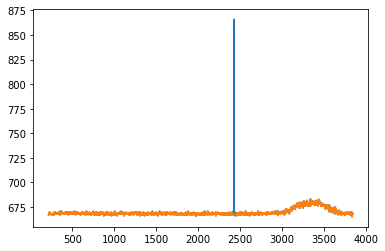

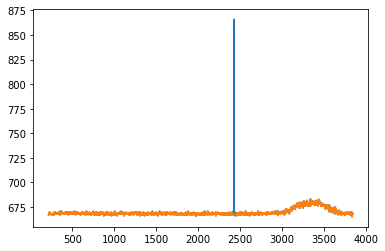

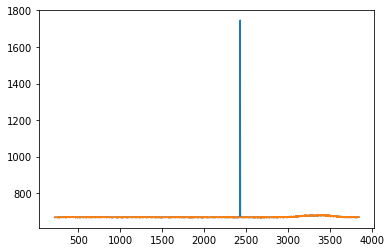

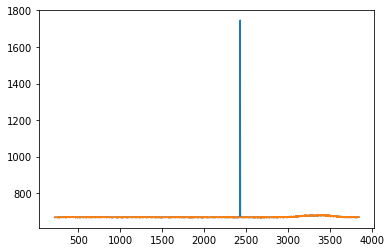

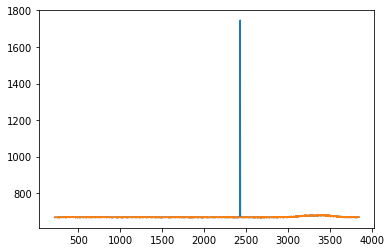

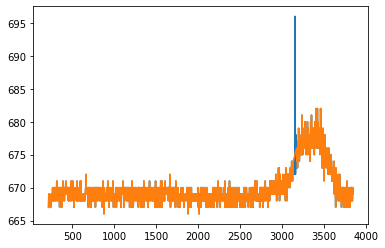

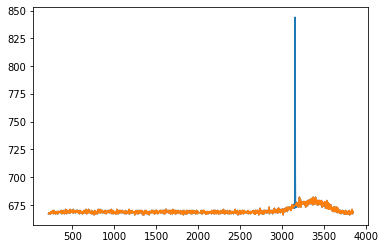

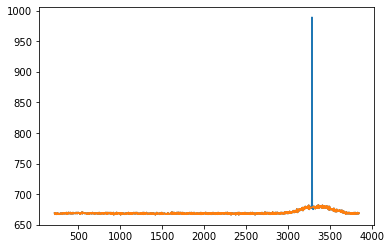

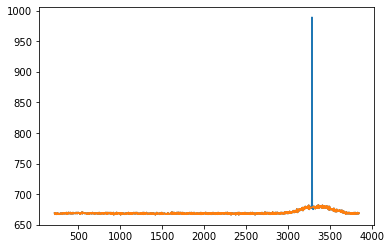

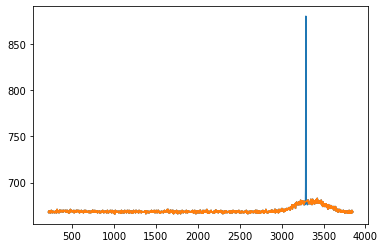

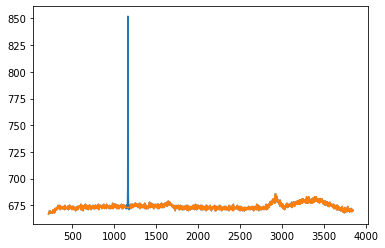

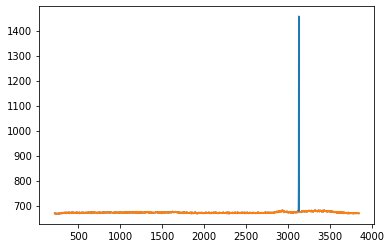

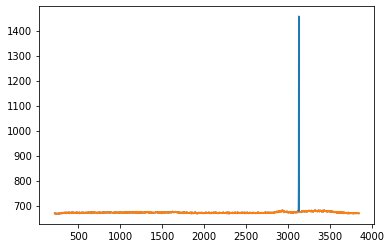

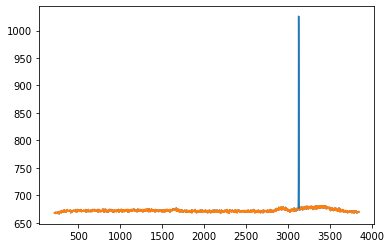

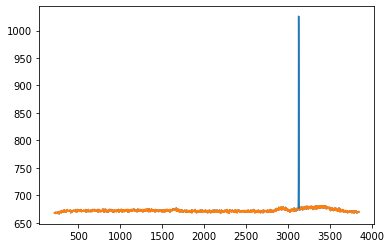

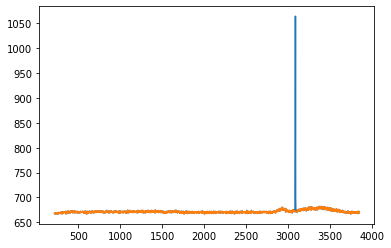

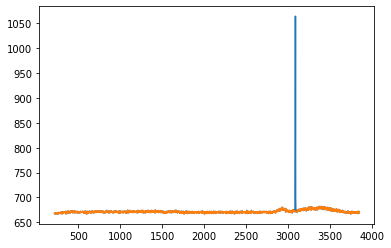

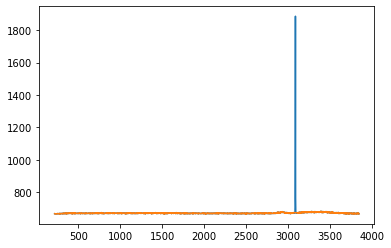

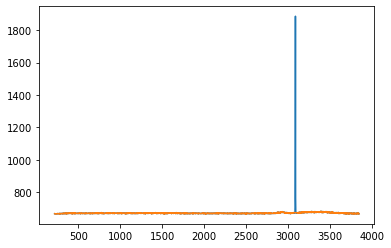

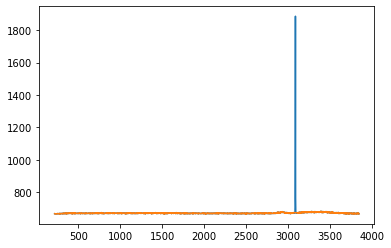

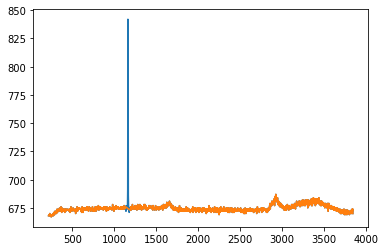

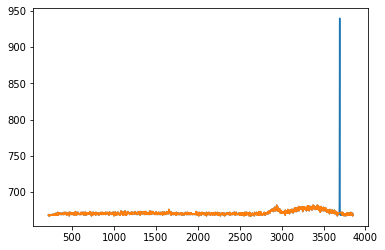

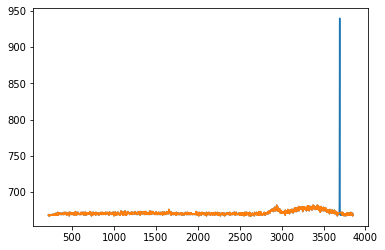

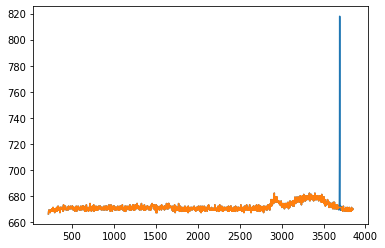

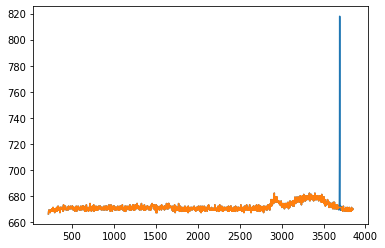

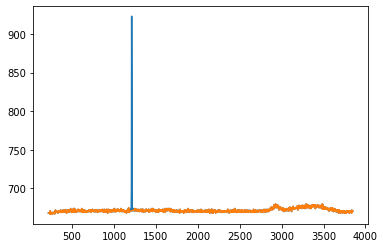

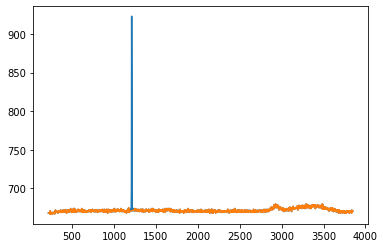

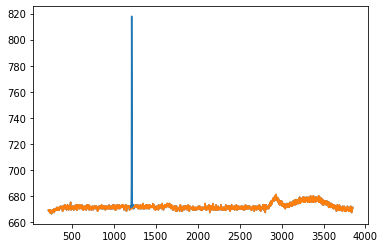

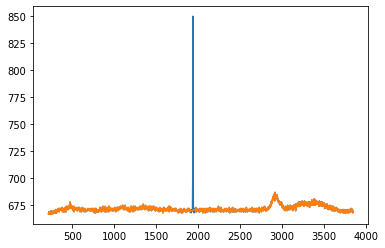

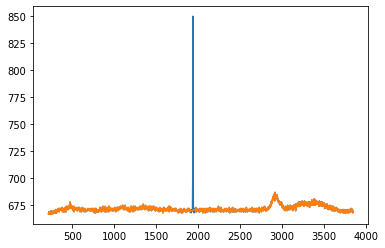

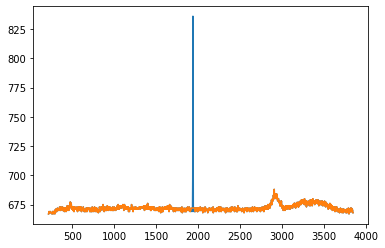

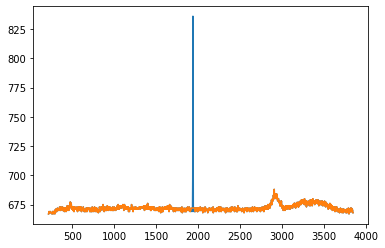

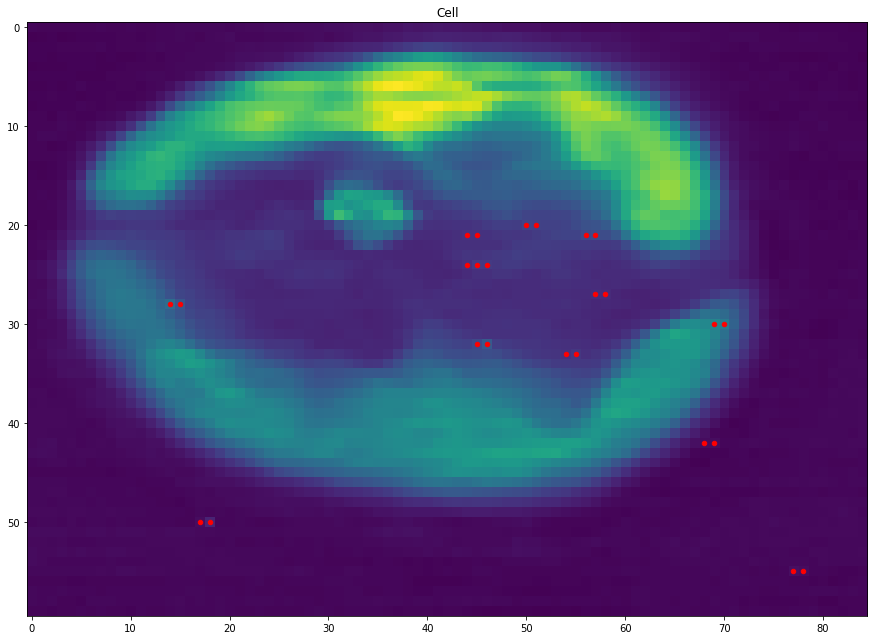

In [6]:
from sklearn import cluster
from scipy import signal

th = 14 # 14.5 ozkouseno
cell = "Cryptomonas" # "Bigelowiella" "Cryptomonas" "Penium" "a" "Glenodinium"
data = Data(f"./data/{cell}.mat")

def calculate_Z_scores(data) -> np.ndarray:
    row_data = np.diff(data, axis=1)
    M_row = np.median(row_data)
    MAD_row = np.median(np.abs(row_data - M_row))
    Z_row = 0.6745 * (row_data - M_row) / MAD_row
    return Z_row

def calculate_Z_scores_col(data) -> np.ndarray:
    col_data = data.T
    M = np.median(col_data, axis=1)
    wide_M = np.repeat(M[:,np.newaxis], col_data.shape[1], axis=1)
    MAD = np.median(np.abs(col_data - wide_M), axis=1)
    wide_MAD = np.repeat(MAD[:,np.newaxis], col_data.shape[1], axis=1)
    Z = 0.6745 * (col_data - wide_M) / wide_MAD
    # print(Z.shape)
    return Z

# TODO: experimentovat s th, cluster sizem, nejak rict ze nepotrebuji konektivitu?
#  pripadne rozvolnit threshold a pak rict, ze dany "top" se objevuje tolikrat, ze to pravdepodobne neni peak

# u cryptomonas takto funguje dobre!
n_comp = 10
clf = cluster.MiniBatchKMeans(n_clusters=n_comp, random_state=42) # cluster.KMeans(n_clusters=n_comp, random_state=42), 10 comps
flattened_data = np.reshape(data.data, (-1, data.data.shape[-1]))[:,get_indices_to_fit(data.x_axis, [[1900, 2600]])] #1900,2600
clf.fit(flattened_data)

result = clf.predict(flattened_data)

comp_im = np.reshape(result, data.data.shape[:2])
plt.imshow(comp_im.T, interpolation='nearest')
plt.axis('off')
plt.title("Comps")

cluster_map = np.reshape(result, data.data.shape[:2])
# print(cluster_map)

comps = {}
zets = {}
positions = []

# get peaks positions
for i in range(n_comp):
    comps[i] = np.asarray(np.where(cluster_map == i)).T
    # print(data.data[comps[i][:, 0], comps[i][:, 1], :].shape)
    zets[i] = calculate_Z_scores(data.data[comps[i][:, 0], comps[i][:, 1], :])
    # print(np.max(zets[i]))
    pos, counts = np.unique(comps[i][np.where(zets[i] > th)[0]], axis=0, return_counts=True)
    # print(pos, counts)
    positions.append(pos)

# remove peaks
for i in range(n_comp):
    for spectrum, spike_pos in np.asarray(np.where(zets[i] > th)).T:
        plt.figure()
        data_to_display = data.data[comps[i][spectrum, 0], comps[i][spectrum, 1], :]
        plt.plot(data.x_axis, data_to_display)
        # find maximum in given window -> spike_pos is rarely on the top, this step ensures it
        spike_window_start = np.maximum(spike_pos - 10, 0)
        spike_window_end = np.minimum(spike_pos + 11, len(data_to_display))
        spike_rel_index = np.argmax(data_to_display[spike_window_start : spike_window_end])
        spike_top = spike_window_start + spike_rel_index
        # _, _, left, right = signal.peak_widths(data_to_display, [spike_top], rel_height=0.9)
        left, right = int(np.maximum(spike_top - 10, 0)), int(np.minimum(spike_top + 11, len(data_to_display)))

        start_value = data_to_display[left]
        end_value = data_to_display[right]
        values_count = right - left 
        new_values = np.linspace(start_value, end_value, num=values_count)
        spikeless_data = np.copy(data_to_display)
        spikeless_data[left:right:1] = new_values

        plt.plot(data.x_axis, spikeless_data)
        # plt.plot(data.x_axis[left], data_to_display[left], "*")
        # plt.plot(data.x_axis[right], data_to_display[right], "*")
        # plt.plot(data.x_axis[spike_pos], data_to_display[spike_pos], "x")
        # plt.plot(data.x_axis[spike_top], data_to_display[spike_top], "o")
        plt.show()

pos = np.vstack(positions)
x = [float(i[0]) for i in pos]
y = [float(i[1]) for i in pos]

plt.figure(figsize=(15,9))
plt.imshow(data.averages.T, zorder=1)
plt.scatter(x, y, color='red', zorder=2, s=20)
plt.axis('on')
plt.title("Cell")

plt.tight_layout()
plt.show()

In [ ]:
# TODO: - zobrazit vsechny ploty s peakem a tam i jeho (jejich) pozici znazornit -> pro kontrolu, kde je
#       - tam pak pro kazdou pozici peaku vzit maximum na nejakem okne
#       - zachovat pouze unikatni souradnice peaku
#       [- pres scipy urcit sirku peaku -> vyda souradnice konce a zacatku] nemusi se delat, proste vzdy vezmu nejake okno a hotovo :))
#       - odstranit cely peak tim, ze se nahradi interpolaci bodu zacatku a konce (+ nejaky shift pro jistotu jeste)

# DONE

# erPLS baseline correction

In [ ]:
# insert gaussian peak to the data -> RMSE, select opt lambda -> perform sub.

# artificial spectrum creation for algorithms comparisons

In [ ]:
# make spectrum with Lorenzian/Gaussian peaks + noise